In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
from ast import arg

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from wlcorr import EncoderDecoderStaticDataset, EncoderDecoder1DCNN_LSTM

from matplotlib import pyplot as plt
import numpy as np

from torchinfo import summary

In [3]:
class VRLoss(nn.Module):

    def __init__(self, w_cos1 = 1., w_cos2 = 1., w_l2 = 2.) -> None:
        super().__init__()
        self.cosinesim1 = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.cosinesim2 = nn.CosineSimilarity(dim=2, eps=1e-6)
        self.l2 = nn.L1Loss()
        s = w_cos1 + w_cos2 + w_l2
        self.w_cos1, self.w_cos2, self.w_l2 = w_cos1/s, w_cos2/s, w_l2/s

    def forward(self, output:torch.Tensor, target:torch.Tensor):
        b, n, _ = output.shape
        sim1 = -self.cosinesim1(output, target)
        sim2 = -self.cosinesim2(output, target)
        l2 = self.l2(output, target)/100.

        l = self.w_cos1*(sim1.exp().mean()-1e-1) + self.w_cos2*(sim2.exp().mean()-1e-1) - self.w_l2*l2.log()
        
        return l

In [4]:
dataset = EncoderDecoderStaticDataset('/home/shivampr21/DKLabs/OilGasProject/WellLogCorrelation/data', patch_size=50-2, sig_smoothening=3)
dataset.dataset.wells_list = dataset.dataset.wells_list.repeat(5)
dataloader = DataLoader(dataset, batch_size = 16, shuffle = True, num_workers = 6)
data_len = len(dataloader)
log_n = int(data_len//2)

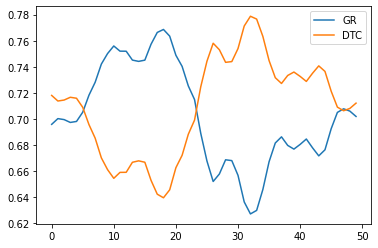

In [5]:
sample_data = dataset[2]
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
model = EncoderDecoder1DCNN_LSTM(1, in_size=50, activation=nn.SELU, norm_layer=None)
model.to(device)
model.train()

[26, 10]


EncoderDecoder1DCNN_LSTM(
  (encoder): Encoder1DCNN_LSTM(
    (activation): SELU()
    (cnn1): Conv1d(1, 5, kernel_size=(5,), stride=(1,))
    (lstm1): LSTM(5, 5, batch_first=True)
    (cnn2): Conv1d(5, 10, kernel_size=(5,), stride=(1,))
    (lstm2): LSTM(10, 10, batch_first=True)
    (cnn3): Conv1d(10, 20, kernel_size=(5,), stride=(1,))
    (lstm3): LSTM(20, 20, batch_first=True)
    (cnn4): Conv1d(20, 20, kernel_size=(5,), stride=(1,))
    (lstm4): LSTM(20, 20, batch_first=True)
    (cnn5): Conv1d(20, 20, kernel_size=(5,), stride=(1,))
    (lstm5): LSTM(20, 20, batch_first=True)
    (conv_last): Conv1d(20, 10, kernel_size=(5,), stride=(1,))
  )
  (decoder): Decoder1DCNN_LSTM(
    (activation): SELU()
    (cnn1): ConvTranspose1d(10, 20, kernel_size=(5,), stride=(1,))
    (lstm1): LSTM(20, 5, batch_first=True)
    (cnn2): ConvTranspose1d(5, 10, kernel_size=(5,), stride=(1,))
    (lstm2): LSTM(10, 10, batch_first=True)
    (cnn3): ConvTranspose1d(10, 5, kernel_size=(5,), stride=(1,))
  

In [9]:
summary(model, (11*2, 1, 50))

Layer (type:depth-idx)                   Output Shape              Param #
EncoderDecoder1DCNN_LSTM                 --                        --
├─Encoder1DCNN_LSTM: 1-1                 [22, 10, 26]              --
│    └─Conv1d: 2-1                       [22, 5, 46]               30
│    └─SELU: 2-2                         [22, 46, 5]               --
│    └─LSTM: 2-3                         [22, 46, 5]               240
│    └─Conv1d: 2-4                       [22, 10, 42]              260
│    └─SELU: 2-5                         [22, 42, 10]              --
│    └─LSTM: 2-6                         [22, 42, 10]              880
│    └─Conv1d: 2-7                       [22, 20, 38]              1,020
│    └─SELU: 2-8                         [22, 38, 20]              --
│    └─LSTM: 2-9                         [22, 38, 20]              3,360
│    └─Conv1d: 2-10                      [22, 20, 34]              2,020
│    └─SELU: 2-11                        [22, 34, 20]              --
│  

In [10]:
criterion =  VRLoss(w_cos1=0.0, w_cos2=0.5, w_l2=2.0) # Loss function
params_list = model.parameters() # model parameters
optimizer = optim.AdamW(params_list, lr = 0.00001, weight_decay=0.000001)

In [11]:
def compute_loss(dl, model, crt):
    total_loss = 0.
    cnt = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dl:
            data = data.to(device)
            data_ = torch.cat(data.split(1, dim=1), dim=0)
            
            # calculate outputs by running images through the network
            output = model(data_)
            output = torch.cat(output.split(output.shape[0]//2, dim=0), dim=1)

            loss = crt(output, data)
            
            # print(predicted, labels)
            total_loss += loss.item()*data.size(0)
            cnt += data.size(0)
    return total_loss/cnt

In [12]:
rll = []
total_loss = []

In [37]:
model.train()
total_loss += [compute_loss(dataloader, model, criterion)]
print(f'Total loss : {total_loss[-1]}')
for epoch in range(1000):
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        data = data.to(device) # Move data to target device
        data_ = torch.cat(data.split(1, dim=1), dim=0)

        # zero the parameter gradients
        optimizer.zero_grad()

        output = model(data_)
        output = torch.cat(output.split(output.shape[0]//2, dim=0), dim=1)
                
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i%log_n == log_n-1:
            rll += [epoch, i, running_loss]
            print(f'Epoch : {epoch}, Iteration : {i},Running loss : {running_loss/log_n}')
            running_loss = 0
    total_loss += [compute_loss(dataloader, model, criterion)]
    print(f'Total loss : {total_loss[-1]}')

Total loss : 4.152700036885787
Epoch : 0, Iteration : 14,Running loss : 4.151312446594238
Epoch : 0, Iteration : 29,Running loss : 4.148819255828857
Total loss : 4.149564649620834
Epoch : 1, Iteration : 14,Running loss : 4.14989824295044
Epoch : 1, Iteration : 29,Running loss : 4.155273087819418
Total loss : 4.1511853101302165
Epoch : 2, Iteration : 14,Running loss : 4.150835100809733
Epoch : 2, Iteration : 29,Running loss : 4.147069581349691
Total loss : 4.150806968066157
Epoch : 3, Iteration : 14,Running loss : 4.153982480367024
Epoch : 3, Iteration : 29,Running loss : 4.151173496246338
Total loss : 4.149901341418831
Epoch : 4, Iteration : 14,Running loss : 4.148563798268636
Epoch : 4, Iteration : 29,Running loss : 4.153293323516846
Total loss : 4.150753054326894
Epoch : 5, Iteration : 14,Running loss : 4.151071198781332
Epoch : 5, Iteration : 29,Running loss : 4.149477036794027
Total loss : 4.148075726567482
Epoch : 6, Iteration : 14,Running loss : 4.147484715779623
Epoch : 6, Itera

Epoch : 54, Iteration : 29,Running loss : 4.153085295359293
Total loss : 4.151726561176534
Epoch : 55, Iteration : 14,Running loss : 4.152115694681803
Epoch : 55, Iteration : 29,Running loss : 4.14981689453125
Total loss : 4.148643036277926
Epoch : 56, Iteration : 14,Running loss : 4.149141883850097
Epoch : 56, Iteration : 29,Running loss : 4.153956953684489
Total loss : 4.149144192131198
Epoch : 57, Iteration : 14,Running loss : 4.151470979054769
Epoch : 57, Iteration : 29,Running loss : 4.14952278137207
Total loss : 4.151212964739118
Epoch : 58, Iteration : 14,Running loss : 4.153554058074951
Epoch : 58, Iteration : 29,Running loss : 4.149771086374918
Total loss : 4.151849384697116
Epoch : 59, Iteration : 14,Running loss : 4.149257373809815
Epoch : 59, Iteration : 29,Running loss : 4.15016409556071
Total loss : 4.149783188956125
Epoch : 60, Iteration : 14,Running loss : 4.149961980183919
Epoch : 60, Iteration : 29,Running loss : 4.150180371602376
Total loss : 4.150139783353222
Epoch 

KeyboardInterrupt: 

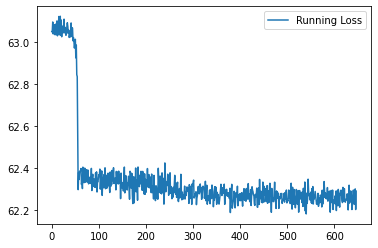

In [38]:
plt.plot(np.array(rll).reshape((-1, 3))[:, 2], label='Running Loss')
plt.legend()
plt.show()

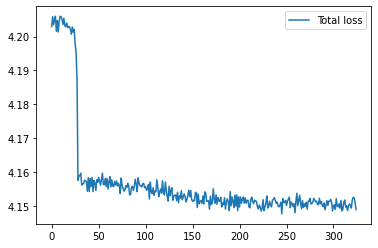

In [39]:
plt.plot(total_loss, label='Total loss')
plt.legend()
plt.show()

In [40]:
torch.save(model.state_dict(), './modelstate_lstm_cnn_v1')

In [41]:
model.eval()

EncoderDecoder1DCNN_LSTM(
  (encoder): Encoder1DCNN_LSTM(
    (activation): SELU()
    (cnn1): Conv1d(1, 5, kernel_size=(5,), stride=(1,))
    (lstm1): LSTM(5, 5, batch_first=True)
    (cnn2): Conv1d(5, 10, kernel_size=(5,), stride=(1,))
    (lstm2): LSTM(10, 10, batch_first=True)
    (cnn3): Conv1d(10, 20, kernel_size=(5,), stride=(1,))
    (lstm3): LSTM(20, 20, batch_first=True)
    (cnn4): Conv1d(20, 20, kernel_size=(5,), stride=(1,))
    (lstm4): LSTM(20, 20, batch_first=True)
    (cnn5): Conv1d(20, 20, kernel_size=(5,), stride=(1,))
    (lstm5): LSTM(20, 20, batch_first=True)
    (conv_last): Conv1d(20, 10, kernel_size=(5,), stride=(1,))
  )
  (decoder): Decoder1DCNN_LSTM(
    (activation): SELU()
    (cnn1): ConvTranspose1d(10, 20, kernel_size=(5,), stride=(1,))
    (lstm1): LSTM(20, 5, batch_first=True)
    (cnn2): ConvTranspose1d(5, 10, kernel_size=(5,), stride=(1,))
    (lstm2): LSTM(10, 10, batch_first=True)
    (cnn3): ConvTranspose1d(10, 5, kernel_size=(5,), stride=(1,))
  

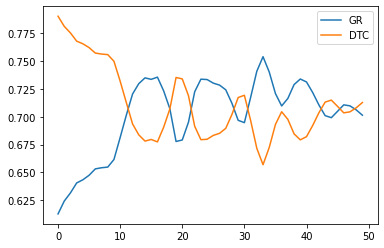

In [42]:
sample_data = dataset[11]
# sample_data[0, :] = torch.from_numpy(np.convolve(sample_data[0, :].numpy(), np.ones(5), mode='same'))
# sample_data[1, :] = torch.from_numpy(np.convolve(sample_data[1, :].numpy(), np.ones(5), mode='same'))
# sample_data = sample_data[:, 4:-5]
plt.plot(sample_data[0, :], label='GR')
plt.plot(sample_data[1, :], label='DTC')
plt.legend()
plt.show()

In [43]:
sample_data_ = sample_data.unsqueeze(dim=0).to(device)
reconst_data = model(torch.cat(sample_data_.split(1, dim=1), dim=0))
reconst_data = torch.cat(output.split(reconst_data.shape[0]//2, dim=0), dim=1)
reconst_data = reconst_data.detach().cpu().squeeze(dim=0).numpy()

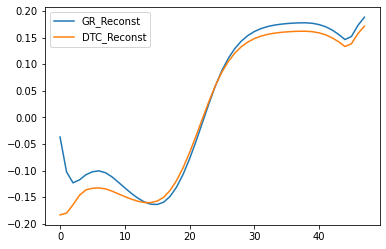

In [44]:
plt.plot(reconst_data[1, :-2], label='GR_Reconst')
plt.plot(reconst_data[0, :-2], label='DTC_Reconst')
plt.legend()
plt.show()